In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [32]:
if os.path.exists('/content/clouds.jpeg'):
    print('Nanda Devi Scenic Vistas.jpeg exists')
else:
    !wget https://images.beta.cosmos.so/d78acac2-6f14-4bc4-a2ba-1e0e07c00f76?format=jpeg -O /content/NandaDevi.jpeg.jpg

--2024-09-20 11:14:48--  https://images.beta.cosmos.so/d78acac2-6f14-4bc4-a2ba-1e0e07c00f76?format=jpeg
Resolving images.beta.cosmos.so (images.beta.cosmos.so)... 3.163.80.108, 3.163.80.30, 3.163.80.27, ...
Connecting to images.beta.cosmos.so (images.beta.cosmos.so)|3.163.80.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67624 (66K) [image/jpeg]
Saving to: ‘/content/NandaDevi.jpeg.jpg’

/content/NandaDevi. 100%[===================>]  66.04K  --.-KB/s    in 0.03s   

2024-09-20 11:14:48 (2.55 MB/s) - ‘/content/NandaDevi.jpeg.jpg’ saved [67624/67624]



In [33]:
img = torchvision.io.read_image("/content/NandaDevi.jpeg.jpg")
print(img.shape)

torch.Size([3, 1350, 1080])


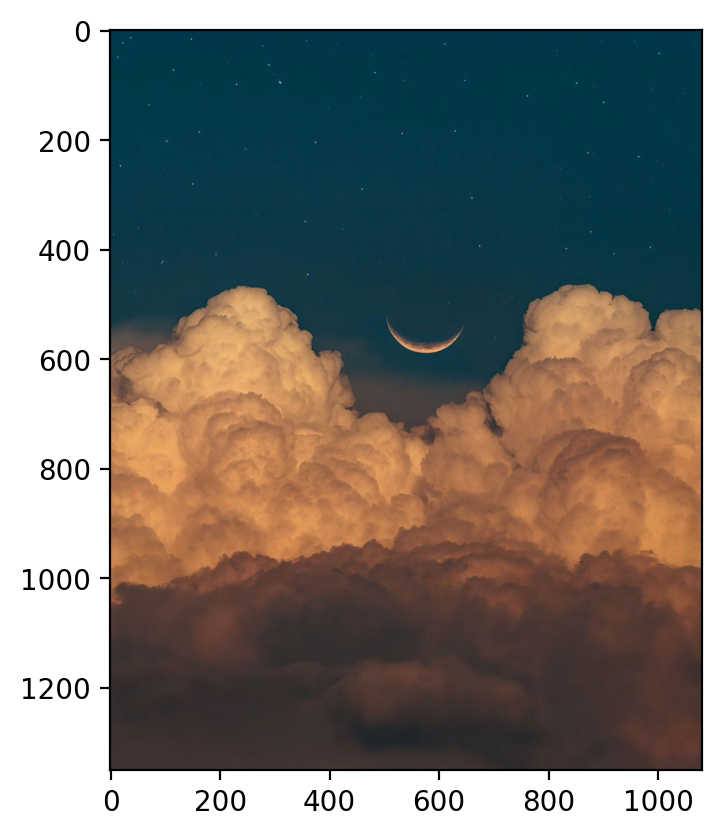

In [34]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler_img = MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img


MinMaxScaler()

In [36]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape


(3, 1350, 1080)

In [37]:
img_scaled = torch.tensor(img_scaled)
img_scaled

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2431, 0.2431, 0.2431,  ..., 0.3020, 0.3020, 0.3020],
         [0.2431, 0.2431, 0.2431,  ..., 0.3020, 0.3020, 0.3020],
         [0.2431, 0.2431, 0.2431,  ..., 0.3020, 0.3020, 0.3020]],

        [[0.2157, 0.2157, 0.2157,  ..., 0.2157, 0.2157, 0.2157],
         [0.2157, 0.2157, 0.2157,  ..., 0.2157, 0.2157, 0.2157],
         [0.2157, 0.2157, 0.2157,  ..., 0.2157, 0.2157, 0.2157],
         ...,
         [0.2039, 0.2039, 0.2039,  ..., 0.2118, 0.2118, 0.2118],
         [0.2039, 0.2039, 0.2039,  ..., 0.2118, 0.2118, 0.2118],
         [0.2039, 0.2039, 0.2039,  ..., 0.2118, 0.2118, 0.2118]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2941, 0.2941, 0.2941],
         [0.2941, 0.2941, 0.2941,  ..., 0.2941, 0.2941, 0.2941],
         [0.2941, 0.2941, 0.2941,  ..., 0.2941, 0.2941, 0.

In [38]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 450, 250, 300, 300)
crop.shape

torch.Size([3, 300, 300])

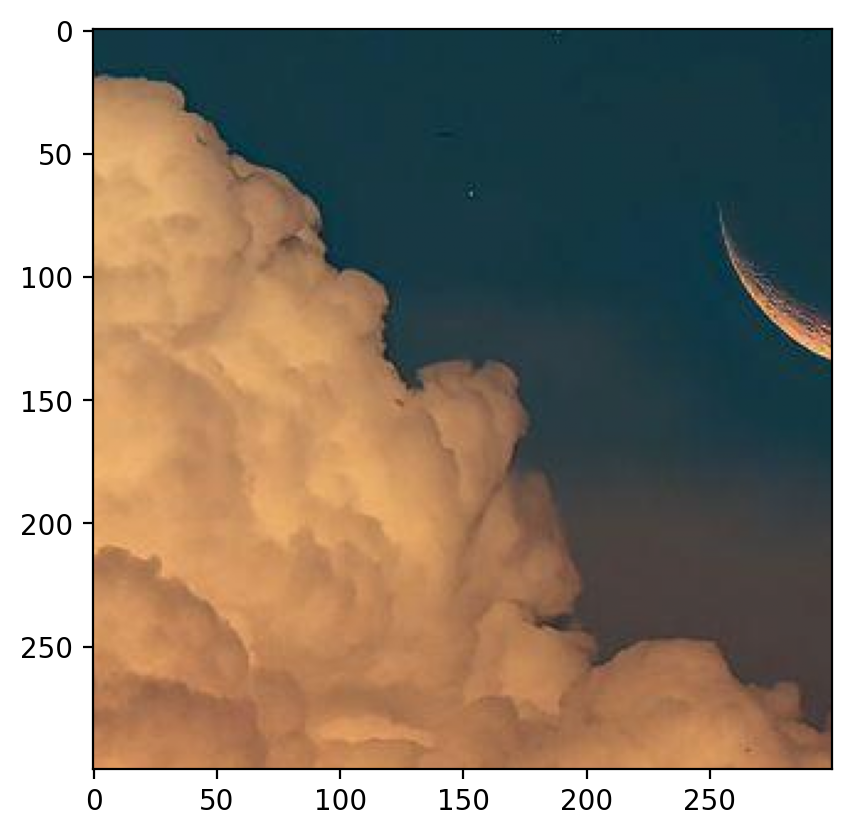

In [39]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [40]:
crop= crop.to(device)

In [41]:
print(device)

cuda


In [42]:
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [43]:
def create_coordinate_map(image):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = image.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(image, 'c h w -> (h w) c').float()
    return X, Y

In [44]:
NandaDevi_X, NandaDevi_Y = create_coordinate_map(crop)

NandaDevi_X.shape, NandaDevi_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [45]:
# MinMaxScaler from -1 to 1
scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(NandaDevi_X.cpu())

# Scale the X coordinates
NandaDevi_X_scaled = scaler_X.transform(NandaDevi_X.cpu())

# Move the scaled X coordinates to the GPU
NandaDevi_X_scaled = torch.tensor(NandaDevi_X_scaled).to(device)

# Set to dtype float32
NandaDevi_X_scaled = NandaDevi_X_scaled.float()

In [46]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [47]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [48]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [49]:
X_rff = create_rff_features(NandaDevi_X_scaled, 15000, 0.01)


In [50]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=15000, out_features=3, bias=True)
)

In [51]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [52]:
train(net, 3e-3, X_rff, NandaDevi_Y, 100)

Epoch 0 loss: 0.183975
Epoch 10 loss: 0.158555
Epoch 20 loss: 0.136415
Epoch 30 loss: 0.117302
Epoch 40 loss: 0.101059
Epoch 50 loss: 0.087444
Epoch 60 loss: 0.076164
Epoch 70 loss: 0.066911
Epoch 80 loss: 0.059383
Epoch 90 loss: 0.053299


0.04884888604283333

In [53]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

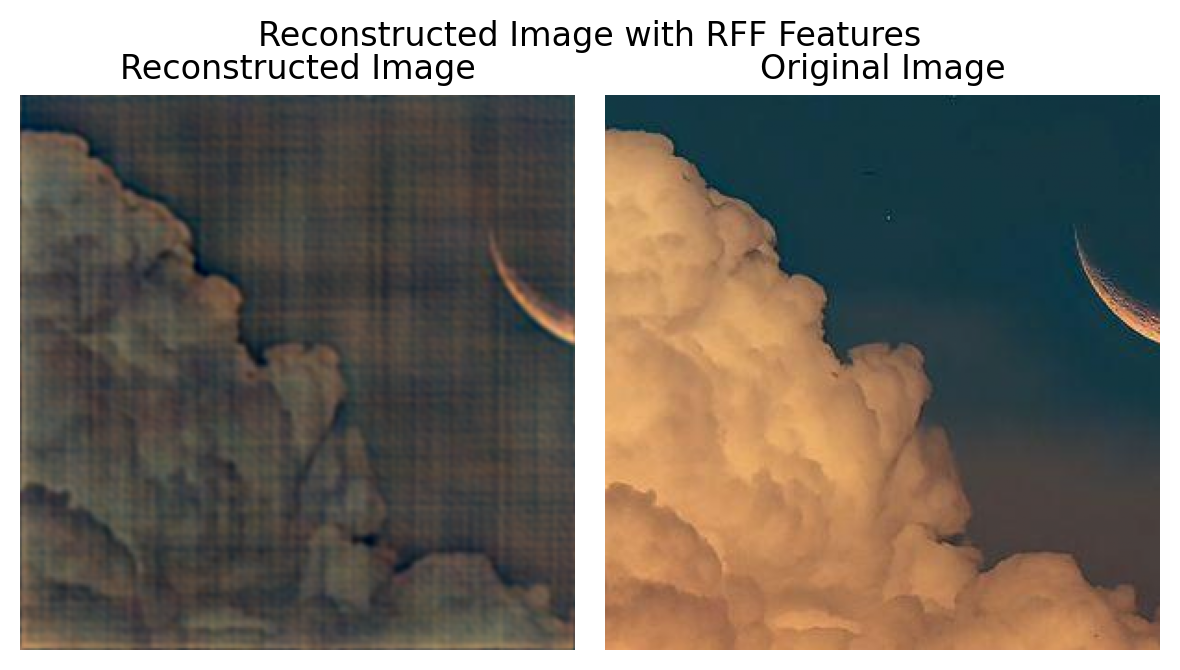

In [54]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [55]:
def calculate_rmse(original_img, reconstructed_img):
    """Calculate the Root Mean Squared Error (RMSE) between the original and reconstructed images."""
    original_img_np = original_img.cpu().numpy()
    reconstructed_img_np = reconstructed_img.cpu().numpy()
    mse = np.mean((original_img_np - reconstructed_img_np) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [56]:
def calculate_psnr(original_img, reconstructed_img):
    """Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images."""
    original_img_np = original_img.numpy()
    reconstructed_img_np = reconstructed_img.numpy()
    mse = np.mean((original_img_np - reconstructed_img_np) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if there is no noise
    max_pixel = 1.0  # Assuming the pixel values are scaled between 0 and 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [57]:
def reconstructed_and_original_image(original_img, net, X):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    outputs = rearrange(outputs, ' h w c -> c h w ')
    print(outputs.shape)
    return  outputs.cpu(), original_img.cpu()

In [58]:
reconstructed, original = reconstructed_and_original_image(crop, net, X_rff)

torch.Size([3, 300, 300])


In [59]:
rmse = calculate_rmse(original, reconstructed)
rmse

0.22001539672788145

In [60]:
psnr = calculate_psnr(original, reconstructed)
psnr

13.150938521739153